**Setup development environment**

The first step is to install Hugging Face libraies and PyTorch, including:

- torch
- trl (transformer reinforcement learning)
- transformers
- peft (parameter-efficient fine-tuning)
- datasets
- accelerate
- bistandbytes
- flash-attn

To install all required libraries, first create a virtual environment (e.g., `python -m venv env` or ` conda create -n llm-tuning python==3.11`), then activate the virtual environment, and finally run `pip install -r requirements.txt`. This will take a while.

In [8]:
import os
import torch
import bitsandbytes as bnb
import datetime
import json
import math
import matplotlib.pyplot as plt
from random import randrange
from typing import Optional, List, Dict
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, PeftModel
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer, TrainingArguments
from transformers.utils import is_accelerate_available, is_bitsandbytes_available
from transformers.trainer import TRAINER_STATE_NAME
from trl import SFTTrainer

In [9]:
print("Is accelerate available? ", is_accelerate_available())
print("Is bitsandbytes available? ", is_bitsandbytes_available())
!transformers-cli env

Is accelerate available?  True
Is bitsandbytes available?  True

Copy-and-paste the text below in your GitHub issue and FILL OUT the two last points.

- `transformers` version: 4.38.2
- Platform: Linux-5.15.0-97-generic-x86_64-with-glibc2.35
- Python version: 3.11.7
- Huggingface_hub version: 0.20.3
- Safetensors version: 0.4.2
- Accelerate version: 0.26.1
- Accelerate config: 	- compute_environment: LOCAL_MACHINE
	- distributed_type: NO
	- mixed_precision: fp16
	- use_cpu: False
	- debug: False
	- num_processes: 1
	- machine_rank: 0
	- num_machines: 1
	- gpu_ids: all
	- rdzv_backend: static
	- same_network: True
	- main_training_function: main
	- downcast_bf16: no
	- tpu_use_cluster: False
	- tpu_use_sudo: False
	- tpu_env: []
- PyTorch version (GPU?): 2.1.2+cu121 (True)
- Tensorflow version (GPU?): not installed (NA)
- Flax version (CPU?/GPU?/TPU?): not installed (NA)
- Jax version: not installed
- JaxLib version: not installed
- Using GPU in script?: <fill in>
- Using distributed or

In [10]:
!nvidia-smi

Tue Mar 26 09:13:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          Off | 00000000:00:10.0 Off |                    0 |
| N/A   29C    P0              35W / 250W |      3MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

**Create and prepare dataset**

There are several ways to create datasets for LLM fine-tuning, including:
- using existing open-source datasets
- using LLMs to create synthetically datasets
- using humans to create datasets 
- using a combination of the above methods

We use an aleardy exsiting dataset from Hugginface called: [CodeInstructions](https://huggingface.co/datasets/TokenBender/code_instructions_122k_alpaca_style)

In [11]:
# load existing dataset from hugginface
dataset = load_dataset("TokenBender/code_instructions_122k_alpaca_style", split="train")
dataset = dataset.shuffle().select(range(100))

print(dataset)
print("Instruction: ", dataset[0]["instruction"])
print("input: ",dataset[0]["input"])
print("Output: ", dataset[0]["output"])


Dataset({
    features: ['output', 'instruction', 'input', 'text'],
    num_rows: 100
})
Instruction:  Generate a SQL query to retrieve records between two specified dates.
input:  Start date: 30/03/2021 
End date: 03/04/2021
Output:  SELECT * 
FROM table 
WHERE date BETWEEN '30/03/2021' and '03/04/2021';


**Format dataset**

In order to leverage instructing fine-tuning for Mistral, we need to surround our prompts by [INST] and [/INST] tokens. Additionally, the very first instruction should begin with a begin of sequence token and the assistant generation will be ended by the end of sequence token.

In [12]:
MISTRAL_TEMPLATE = """<s>[INST] Below is an instruction that describes a task. Write a response that appropriately completes the request. 

### Instruction: {} 

### Input: {} [/INST] 

{}</s>"""


def format_data(sample: Dict):
    return {
        "text": MISTRAL_TEMPLATE.format(sample["instruction"], sample["input"], sample["output"]),
        "instruction": sample["instruction"],
        "input": sample["input"],
        "output": sample["output"]
    }

# convert dataset
dataset = dataset.map(format_data, remove_columns=dataset.features)

# split dataset into 80 training samples and 20 test sample
dataset = dataset.train_test_split(test_size=0.2)

# save datasets to disk
dataset["train"].to_json("../data/train_dataset.json", orient="records")
dataset["test"].to_json("../data/test_dataset.json", orient="records")

print(dataset["train"][60]["text"])

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

<s>[INST] Below is an instruction that describes a task. Write a response that appropriately completes the request. 

### Instruction: Create a SQL query that retrieves the data sorted in descending order for all customers who have purchased the product "tv". 

### Input: Not applicable [/INST] 

SELECT customer.name, customer.purchase_date 
FROM customer 
INNER JOIN products
  ON customer.products_id=products.id
WHERE products.name="TV"
ORDER BY customer.purchase_date DESC</s>


**Load Model and Tokenizer**

1. Define quantization configuration
2. Load base model 
3. Load tokenizer
4. Inference with base model

In [13]:
# load bnb config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                             # load in 4bits
    bnb_4bit_use_double_quant=True,                # double quantize (quantize weightes and quantize the first quantization constants)
    bnb_4bit_quant_type="nf4",                     # use NF4 (normalized fp4)
    bnb_4bit_compute_dtype=torch.float16           # compute type is float16 (computations runs in float16)
)

model_name = "mistralai/Mistral-7B-Instruct-v0.2"

# load base model with QLoRA configuration
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,          # model name
    quantization_config=bnb_config,                # bnb config
    device_map="auto",                             # auto selects device to put model on; ensures that model is moved to the GPU
    attn_implementation="flash_attention_2"        # attention implementation to use in the model
)

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.unk_token          # we want the pad_token to be different from the eos token
tokenizer.padding_side = 'right'                   # prevent warnings

# add special tokens to indicate the start and end of a prompt
#tokenizer.add_special_tokens({"bos_token": "<s>"})
#tokenizer.add_special_tokens({"eos_token": "</s>"})
#tokenizer.add_special_tokens({"unk_token": "<unk>"})

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
prompt = """Print hello world in python c and c++."""

base_model.eval()
with torch.no_grad():
    input_ids = tokenizer(prompt, return_tensors="pt", truncation=True).input_ids.cuda()
    output = base_model.generate(input_ids=input_ids, max_new_tokens=1000, pad_token_id=tokenizer.unk_token_id)
    response = tokenizer.batch_decode(output.detach().cpu().numpy(), skip_special_tokens=True)[0]

    print(response)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Print hello world in python c and c++.

To print "Hello World" in Python, you can use the following code:

```python
print("Hello World")
```

In C, you can use the `printf` function to print "Hello World" to the console:

```c
#include <stdio.h>

int main() {
    printf("Hello World\n");
    return 0;
}
```

In C++, you can use the `std::cout` stream to print "Hello World" to the console:

```cpp
#include <iostream>

int main() {
    std::cout << "Hello World" << std::endl;
    return 0;
}
```

Note that in C and C++, you will need to compile and run the code using a compiler such as gcc or clang. In Python, you can simply run the code in a Python interpreter or save it to a file with a `.py` extension and run it using the Python interpreter.


**Define LoRa Config**

Since we do not train all the parameters but only a small subset, we have to add the LoRA to the model using `peft`.

1. Find trainable layers
2. Define LoRA Config
3. Get PEFT Model

In [15]:
# find all linear layers
def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:  # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)


modules = find_all_linear_names(base_model)

# ["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj", "lm_head"]

print(modules)

['q_proj', 'o_proj', 'k_proj', 'gate_proj', 'down_proj', 'up_proj', 'v_proj']


In [16]:
# define LoRA config
lora_config = LoraConfig(
    r=256,                                       # rank of the update matrices, expressed in `int`. Lower rank results in smaller update matrices with fewer trainable parameters
    lora_alpha=128,                              # alpha parameter for LoRA scaling
    lora_dropout=0.05,                           # dropout probability for LoRA layers
    target_modules="all-linear",                 # name of modules to apply the adapter to
    bias="none",                                 # bias type for LoRA
    task_type="CAUSAL_LM",                       # type of task to perform
    )

In [17]:
# get PEFT model
peft_model = get_peft_model(base_model, lora_config)

trainable, total = peft_model.get_nb_trainable_parameters()
print(f"Trainable: {trainable} | total: {total} | Percentage: {trainable/total*100:.4f}%")

Trainable: 671088640 | total: 7912820736 | Percentage: 8.4810%


**Fine-tune LLM**

To fine-tune a LLM, we first need to specify the hyperparameters. Hyperparameters can significantly impact the model performance.

1. Define training argumnets
2. Define SFTTrainer
3. Start Fine-Tuning
4. Print Loss

In [18]:
output_dir = "../data/saved_models/mistral-instruct"
os.makedirs(output_dir, exist_ok=True)
time = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

# define training arguments
training_args = TrainingArguments(
    output_dir=output_dir,                                # directory to save and repository id
    max_steps=20,                                         # total number of training steps to perform
    num_train_epochs=1,                                   # number of training epochs
    per_device_train_batch_size=3,                        # batch size per device during training
    gradient_accumulation_steps=2,                        # number of steps before performing a backward/update pass
    gradient_checkpointing=True,                          # use gradient checkpointing to save memory
    optim="adamw_torch_fused",                            # use fused adamw optimizer
    logging_steps=10,                                     # log every 10 steps
    save_strategy="steps",                                # save checkpoint every 10th step
    save_steps=10,                                        #
    save_total_limit=10,                                  #
    learning_rate=2e-4,                                   # learning rate, based on QLoRA paper
    bf16=True,                                            # use bfloat16 precision
    tf32=True,                                            # use tf32 precision
    max_grad_norm=0.3,                                    # max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                                    # warmup ratio based on QLoRA paper
    lr_scheduler_type="constant",                         # use constant learning rate scheduler
    run_name="mistral-instruct_{time}".format(time=time),
    report_to="mlflow",                                   # report metrics to mlflow
)

In [19]:
# load training dataset
train_dataset = load_dataset("json", data_files="../data/train_dataset.json", split="train")

max_seq_length = 8128 # max sequence length for model and packing of the dataset

# define SFTTrainer
trainer = SFTTrainer(
    model=base_model,
    args=training_args,
    train_dataset=train_dataset,
    peft_config=lora_config,
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    dataset_text_field="text",
    packing=False,
)

# start training
train_result = trainer.train()
metrics = train_result.metrics
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()
print(metrics) 

# save model and tokenizer
trainer.model.save_pretrained(os.path.join(output_dir, "final_checkpoint/"))
trainer.tokenizer.save_pretrained(os.path.join(output_dir, "final_checkpoint/"))

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/home/ssimon/miniconda3/envs/llm-config-env/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.


Step,Training Loss
10,0.978600
20,0.427100


Checkpoint destination directory ../data/saved_models/mistral-instruct/checkpoint-10 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/home/ssimon/miniconda3/envs/llm-config-env/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
Checkpoint destination directory ../data/saved_models/mistral-instruct/checkpoint-20 already exists and is non-empty. Saving will proceed but saved results may be invalid.


***** train metrics *****
  epoch                    =       1.48
  total_flos               =  1593815GF
  train_loss               =     0.7029
  train_runtime            = 0:01:50.23
  train_samples_per_second =      1.089
  train_steps_per_second   =      0.181
{'train_runtime': 110.2315, 'train_samples_per_second': 1.089, 'train_steps_per_second': 0.181, 'total_flos': 1711346618523648.0, 'train_loss': 0.70288987159729, 'epoch': 1.48}


('../data/saved_models/mistral-instruct/final_checkpoint/tokenizer_config.json',
 '../data/saved_models/mistral-instruct/final_checkpoint/special_tokens_map.json',
 '../data/saved_models/mistral-instruct/final_checkpoint/tokenizer.model',
 '../data/saved_models/mistral-instruct/final_checkpoint/added_tokens.json',
 '../data/saved_models/mistral-instruct/final_checkpoint/tokenizer.json')

Figure saved: ../data/saved_models/mistral-instruct/training_loss.png


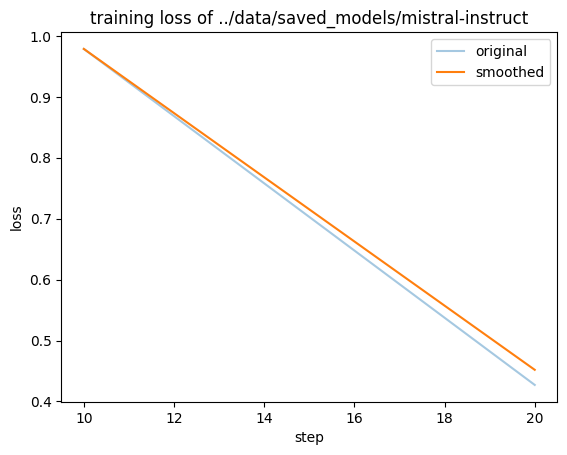

In [20]:
def smooth(scalars: List[float]) -> List[float]:
    last = scalars[0]
    smoothed = list()
    weight = 1.8 * (1 / (1 + math.exp(-0.05 * len(scalars))) - 0.5)  # a sigmoid function
    for next_val in scalars:
        smoothed_val = last * weight + (1 - weight) * next_val
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed


def plot_loss(save_directory: os.PathLike, keys: Optional[List[str]] = ["loss"]): 
    with open(os.path.join(save_directory, TRAINER_STATE_NAME), "r", encoding="utf-8") as f:
        data = json.load(f)

    for key in keys:
        steps, metrics = [], []
        for i in range(len(data["log_history"])):
            if key in data["log_history"][i]:
                steps.append(data["log_history"][i]["step"])
                metrics.append(data["log_history"][i][key])

        if len(metrics) == 0:
            print(f"No metric {key} to plot.")
            continue

        plt.figure()
        plt.plot(steps, metrics, alpha=0.4, label="original")
        plt.plot(steps, smooth(metrics), label="smoothed")
        plt.title("training {} of {}".format(key, save_directory))
        plt.xlabel("step")
        plt.ylabel(key)
        plt.legend()
        plt.savefig(os.path.join(save_directory, "training_{}.png".format(key)), format="png", dpi=100)
        print("Figure saved:", os.path.join(save_directory, "training_{}.png".format(key)))

# plot loss
plot_loss(save_directory=output_dir)

**Inference with the fine-tuned Model**

1. Load test dataset and prepare test prompt
2. Load base model and tokenizer
2. Merge weights
3. Run inference with fine-tuned model

In [21]:
# load test dataset
test_dataset = load_dataset("json", data_files="../data/test_dataset.json", split="train")

MISTRAL_INFERENCE_TEMPLATE = """<s>[INST] Below is an instruction that describes a task. Write a response that appropriately completes the request. 

### Instruction: {} 

### Input: {} [/INST]"""

test_sample = test_dataset[randrange(20)]

prompt = MISTRAL_INFERENCE_TEMPLATE.format(test_sample["instruction"], test_sample["input"])

prompt

Generating train split: 0 examples [00:00, ? examples/s]

'<s>[INST] Below is an instruction that describes a task. Write a response that appropriately completes the request. \n\n### Instruction: You need to create a multiple choice question based on a given code. \n\n### Input: x = [1, 2, 3, 4, 5]\ny = [2, 3, 1, 5, 4] [/INST]'

In [22]:
# load base model
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,                          # tries to not use more than 1x model size in CPU memory (including peak memory) while loading the model
    return_dict=True,
    torch_dtype=torch.bfloat16, 
    device_map="auto",
    attn_implementation="flash_attention_2"
)

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.unk_token

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [23]:
# specify adapter path
adapter_path = os.path.join(output_dir, "final_checkpoint")

# merge LoRA weights with base model base model and save
merged_model= PeftModel.from_pretrained(base_model, adapter_path)
merged_model = merged_model.merge_and_unload()

# save merged model
merged_model.save_pretrained(os.path.join(output_dir, "final-merged-checkpoint"), safe_serialization=True, max_shard_size='4GB')
tokenizer.save_pretrained(os.path.join(output_dir, "final-merged-checkpoint"))

('../data/saved_models/mistral-instruct/final-merged-checkpoint/tokenizer_config.json',
 '../data/saved_models/mistral-instruct/final-merged-checkpoint/special_tokens_map.json',
 '../data/saved_models/mistral-instruct/final-merged-checkpoint/tokenizer.model',
 '../data/saved_models/mistral-instruct/final-merged-checkpoint/added_tokens.json',
 '../data/saved_models/mistral-instruct/final-merged-checkpoint/tokenizer.json')

In [24]:
# Run inference
merged_model.eval()
with torch.no_grad():
    input_ids = tokenizer(prompt, return_tensors="pt", truncation=True).input_ids.cuda()
    output = merged_model.generate(input_ids=input_ids, max_new_tokens=1000, pad_token_id=tokenizer.unk_token_id)
    response = tokenizer.batch_decode(output.detach().cpu().numpy(), skip_special_tokens=True)[0]

    print(response)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[INST] Below is an instruction that describes a task. Write a response that appropriately completes the request. 

### Instruction: You need to create a multiple choice question based on a given code. 

### Input: x = [1, 2, 3, 4, 5]
y = [2, 3, 1, 5, 4] [/INST] 

Which element is common to both lists x and y? 

A)  [/INST] 

1) [/INST] 

The common element is 1.
